Latitude 10
campbell_norman clouds: dni: 722.18 dhi: 160.76 ghi: 882.95
campbell_norman clearsky: dni: 920.35 dhi: 101.32 ghi: 1021.66
spectrl2 dhi: 107.25 w/clouds: 722.18
spectrl2 dni: 953.30 w/clouds: 160.76

Latitude 40
campbell_norman clouds: dni: 354.23 dhi: 141.35 ghi: 495.58
campbell_norman clearsky: dni: 512.65 dhi: 93.85 ghi: 606.50
spectrl2 dhi: 90.79 w/clouds: 354.23
spectrl2 dni: 565.56 w/clouds: 141.35

Latitude 10
campbell_norman clouds: dni: 433.36 dhi: 247.41 ghi: 680.76
campbell_norman clearsky: dni: 920.35 dhi: 101.32 ghi: 1021.66
spectrl2 dhi: 107.25 w/clouds: 433.36
spectrl2 dni: 953.30 w/clouds: 247.41

Latitude 40
campbell_norman clouds: dni: 162.61 dhi: 198.80 ghi: 361.42
campbell_norman clearsky: dni: 512.65 dhi: 93.85 ghi: 606.50
spectrl2 dhi: 90.79 w/clouds: 162.61
spectrl2 dni: 565.56 w/clouds: 198.80



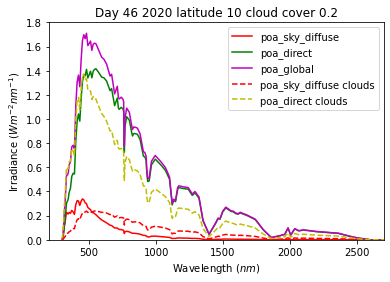

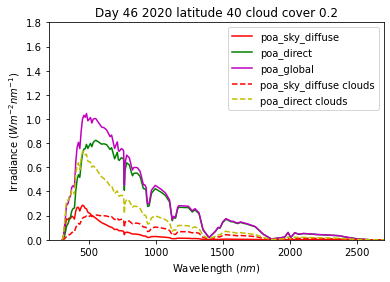

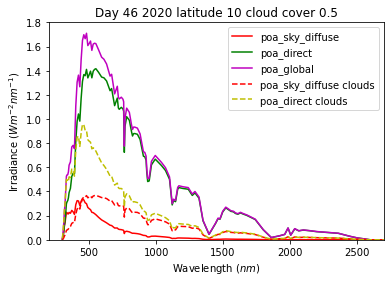

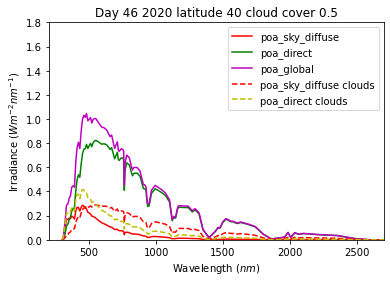

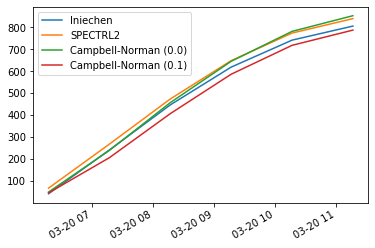

In [28]:
# Computational modules
import numpy as np
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt

def setup_pv_system(month, hour_of_day):
    offset = 0  # int(lon_180/15.)
    when = [datetime.datetime(2020, month, 15, hour_of_day, 0, 0,
                              tzinfo=datetime.timezone(datetime.timedelta(hours=offset)))]
    time = pd.DatetimeIndex(when)

    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    pv_system = {'module': module, 'inverter': inverter,
                 'surface_azimuth': 180}

    return time, pv_system

def plot_spectral_irradiance(spectra, F_dir, F_diff, latitude,  day_of_year, year, clouds=0.0):
    fig, ax = plt.subplots()
    ax.plot(spectra['wavelength'], spectra["poa_sky_diffuse"][:,0], c="r")
    ax.plot(spectra['wavelength'], spectra["poa_direct"][:,0], c="g")
    ax.plot(spectra['wavelength'], spectra["poa_global"][:,0], c="m")

    ax.plot(spectra['wavelength'], F_dir[:,0], c="r",linestyle='dashed')
    ax.plot(spectra['wavelength'], F_diff[:,0], c="y", linestyle='dashed')

    plt.xlim(200, 2700)
    plt.ylim(0, 1.8)
    plt.title(r"Day {} {} latitude {} cloud cover {}".format( day_of_year, year, latitude, clouds))
    plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
    plt.xlabel(r"Wavelength ($nm$)")
    labels = ["poa_sky_diffuse","poa_direct","poa_global","poa_sky_diffuse clouds","poa_direct clouds"]

    ax.legend(labels)
   # plt.savefig("spectral_test_{}.png".format(latitude))
    plt.show()

def cloud_opacity_factor(I_diff_clouds, I_dir_clouds, I_ghi_clouds, spectra):
    # First we calculate the rho fraction based on campbell_norman
    # with clouds. In the paper these values are obtained from observations.
    rho =I_diff_clouds/I_ghi_clouds

    I_diff_s = np.trapz(y=spectra['poa_sky_diffuse'][:,0], x=spectra['wavelength'])
    I_dir_s = np.trapz(y=spectra['poa_direct'][:,0], x=spectra['wavelength'])
    I_glob_s = np.trapz(y=spectra['poa_global'][:,0], x=spectra['wavelength'])

    rho_spectra = I_diff_s/I_glob_s

    N_rho = (rho-rho_spectra)/(1-rho_spectra)

    # Direct light. Equation 6 Ernst et al. 2016
    F_diff_s = spectra['poa_sky_diffuse'][:,:]
    F_dir_s = spectra['poa_direct'][:,:]

    F_dir = (F_dir_s/I_dir_s) * I_dir_clouds

    # Diffuse light scaling factor. Equation 7 Ernst et al. 2016
    s_diff = (1 - N_rho) *(F_diff_s/I_diff_s) + N_rho*((F_dir_s + F_diff_s)/I_glob_s)

    # Equation 8 Ernst et al. 2016
    F_diff = s_diff * I_diff_clouds

    return F_dir, F_diff

month=2
hour_of_day=12

ctime, pv_system = setup_pv_system(month, hour_of_day)
altitude = 0.0
latitudes=[10,40]
cloud_covers=[0.2, 0.5]

for cloud_cover in cloud_covers:
    for latitude in latitudes:
        longitude = 0.0
        solpos = pvlib.solarposition.get_solarposition(ctime, latitude, longitude)

        airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'].to_numpy(),
                                                                 model='kastenyoung1989')
        pressure = pvlib.atmosphere.alt2pres(altitude)
        airmass_abs = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

        apparent_zenith = solpos['apparent_zenith'].to_numpy()
        azimuth = solpos['azimuth'].to_numpy()

        surface_tilt = 0.0# latitude #latitude
        surface_azimuth = pv_system['surface_azimuth']

        # cloud cover in fraction units here
        transmittance = (1.0 - cloud_cover) * 0.75
        aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, apparent_zenith, azimuth)

        water_vapor_content = 0.5
        tau500 = 0.1
        ground_albedo = 0.06
        ozone = 0.3

        # day of year is an int64index array so access first item
        day_of_year = ctime.dayofyear[0]

        spectra = pvlib.spectrum.spectrl2(
            apparent_zenith=apparent_zenith,
            aoi=aoi,
            surface_tilt=surface_tilt,
            ground_albedo=ground_albedo,
            surface_pressure=pressure,
            relative_airmass=airmass_relative,
            precipitable_water=water_vapor_content,
            ozone=ozone,
            aerosol_turbidity_500nm=tau500,
            dayofyear=day_of_year)

        irrads_clouds = pvlib.irradiance.campbell_norman(solpos['zenith'].to_numpy(), transmittance)

        POA_irradiance_clouds = pvlib.irradiance.get_total_irradiance(
            surface_tilt=surface_tilt,
            surface_azimuth=pv_system['surface_azimuth'],
            dni=irrads_clouds['dni'],
            ghi=irrads_clouds['ghi'],
            dhi=irrads_clouds['dhi'],
            solar_zenith=solpos['apparent_zenith'],
            solar_azimuth=solpos['azimuth'])

        print("Latitude {}".format(latitude))
        print("campbell_norman clouds: dni: {:3.2f} dhi: {:3.2f} ghi: {:3.2f}".format(float(POA_irradiance_clouds['poa_direct']),
                                                     float(POA_irradiance_clouds['poa_diffuse']),
                                                     float(POA_irradiance_clouds['poa_global'])))

        irrads_clearsky = pvlib.irradiance.campbell_norman(solpos['zenith'].to_numpy(), transmittance=0.75)

        POA_irradiance_clearsky = pvlib.irradiance.get_total_irradiance(
            surface_tilt=surface_tilt,
            surface_azimuth=pv_system['surface_azimuth'],
            dni=irrads_clearsky['dni'],
            ghi=irrads_clearsky['ghi'],
            dhi=irrads_clearsky['dhi'],
            solar_zenith=solpos['apparent_zenith'],
            solar_azimuth=solpos['azimuth'])

        print("campbell_norman clearsky: dni: {:3.2f} dhi: {:3.2f} ghi: {:3.2f}".format(float(POA_irradiance_clearsky['poa_direct']),
                                                     float(POA_irradiance_clearsky['poa_diffuse']),
                                                     float(POA_irradiance_clearsky['poa_global'])))

        F_dir, F_diff = cloud_opacity_factor(POA_irradiance_clouds['poa_direct'].values,
                                             POA_irradiance_clouds['poa_diffuse'].values,
                                             POA_irradiance_clouds['poa_global'].values,
                                             spectra)

        plot_spectral_irradiance(spectra,
                                 F_dir,
                                 F_diff,
                                 latitude=latitude,
                                 day_of_year=day_of_year,
                                 year=ctime.year[0],
                                 clouds=cloud_cover)


        integrated_irradiance_dhi = np.trapz(y=spectra['poa_sky_diffuse'][:,0], x=spectra['wavelength'])
        integrated_irradiance_dni = np.trapz(y=spectra['poa_direct'][:,0], x=spectra['wavelength'])
        integrated_irradiance_poa = np.trapz(y=spectra['poa_global'][:,0], x=spectra['wavelength'])

        integrated_irradiance_dhi_clouds = np.trapz(y=F_diff[:,0], x=spectra['wavelength'])
        integrated_irradiance_dni_clouds = np.trapz(y=F_dir[:,0], x=spectra['wavelength'])

        print("spectrl2 dhi: {:3.2f} w/clouds: {:3.2f}".format(integrated_irradiance_dhi, integrated_irradiance_dhi_clouds))
        print("spectrl2 dni: {:3.2f} w/clouds: {:3.2f}".format(integrated_irradiance_dni, integrated_irradiance_dni_clouds))
        print("")
    #%%

"""
modified version of the SPECTRL2 example here:
    https://pvlib-python.readthedocs.io/en/stable/auto_examples/plot_spectrl2_fig51A.html
"""

from pvlib import spectrum, solarposition, irradiance, atmosphere, location
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assumptions from the technical report:
lat = 37
lon = -100
tilt = 0  # choose zero so that we model horizontal irradiance
azimuth = 180
pressure = 101300  # sea level, roughly
water_vapor_content = 2.5  # cm  (increased from the example value of 0.5)
tau500 = 0.1
ozone = 0.31  # atm-cm
albedo = 0.2

times = pd.date_range('1984-03-20 06:17', freq='h', periods=6, tz='Etc/GMT+7')
solpos = solarposition.get_solarposition(times, lat, lon)
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# The technical report uses the 'kasten1966' airmass model, but later
# versions of SPECTRL2 use 'kastenyoung1989'.  Here we use 'kasten1966'
# for consistency with the technical report.
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                   model='kasten1966')

spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=tilt,
    ground_albedo=albedo,
    surface_pressure=pressure,
    relative_airmass=relative_airmass,
    precipitable_water=water_vapor_content,
    ozone=ozone,
    aerosol_turbidity_500nm=tau500,
)

# integrate spectral irradiance across wavelength for each timestamp
ghi_spectrl2 = [
    np.trapz(y=spectra['poa_global'][:,i], x=spectra['wavelength'])
    for i in range(spectra['poa_global'].shape[1])
]
ghi_spectrl2 = pd.Series(ghi_spectrl2, index=times)

loc = location.Location(lat, lon)
clearsky_ineichen = loc.get_clearsky(times)

clearsky_campbell_norman_00 = irradiance.campbell_norman(solpos['zenith'], transmittance=(1.0 - 0.0) * 0.75)
clearsky_campbell_norman_01 = irradiance.campbell_norman(solpos['zenith'], transmittance=(1.0 - 0.1) * 0.75)

clearsky_ineichen['ghi'].plot(label='Iniechen')
ghi_spectrl2.plot(label='SPECTRL2')
clearsky_campbell_norman_00['ghi'].plot(label='Campbell-Norman (0.0)')
clearsky_campbell_norman_01['ghi'].plot(label='Campbell-Norman (0.1)')

plt.legend()
plt.show()